In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
data = read_text("../input/bilingual-sentence-pairs/fra.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [5]:
deu_eng = deu_eng[:50000,:]
deu_eng

array([['Go.', 'Va !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'],
       ['Go.', 'Marche.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)'],
       ['Go.', 'Bouge !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)'],
       ...,
       ['Tom liked what he saw.', "Tom a aimé ce qu'il a vu.",
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3729268 (CM) & #5619279 (Aiji)'],
       ['Tom liked what he saw.', "Tom aima ce qu'il vit.",
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3729268 (CM) & #5619280 (Aiji)'],
       ['Tom likes skiing, too.', 'Tom aussi aime skier.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2869208 (CK) & #5591397 (Aiji)']],
      dtype='<U325')

<ul>
    <li style="font-size:100%;">The actual data contains over 150,000 sentence-pairs. However, we will use only the first 50,000 sentence pairs to reduce the training time of the model. You can change this number as per your system’s computation power.</li>
</ul>

In [6]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Va ',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'],
       ['Go', 'Marche',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)'],
       ['Go', 'Bouge ',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)'],
       ...,
       ['Tom liked what he saw', 'Tom a aimé ce quil a vu',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3729268 (CM) & #5619279 (Aiji)'],
       ['Tom liked what he saw', 'Tom aima ce quil vit',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3729268 (CM) & #5619280 (Aiji)'],
       ['Tom likes skiing too', 'Tom aussi aime skier',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2869208 (CK) & #5591397 (Aiji)']],
      dtype='<U325')

In [7]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


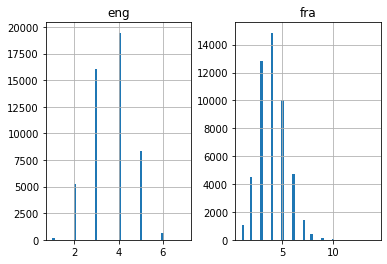

In [8]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'fra':deu_l})

length_df.hist(bins = 50)
plt.show()

<ul>
    <li style="font-size:100%;">A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length.</li>
    <li style="font-size:100%;">Now, vectorize our text data by using Keras’s Tokenizer() class. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.</li>
    <li style="font-size:10
               
               0%;">Prepare tokenizers for both the German and English sentences</li>
</ul>

In [9]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [10]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6042


In [11]:
# prepare French tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('French Vocabulary Size: %d' % deu_vocab_size)

French Vocabulary Size: 13974


In [12]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [13]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

<ul>
    <li style="font-size:100%;"> We will encode German sentences as the input sequences and English sentences as the target sequences. This has to be done for both the train and test datasets.</li>

In [14]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])#input
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])#target

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [15]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [16]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [17]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

<ul>
    <li style="font-size:100%;">We are using the RMSprop optimizer in this model as it’s usually a good choice when working with recurrent neural networks.</li>
    <li style="font-size:100%;">Here I have used ‘sparse_categorical_crossentropy‘ as the loss function. This is because the function allows us to use the target sequence as is, instead of the one-hot encoded format. One-hot encoding the target sequences using such a huge vocabulary might consume our system’s entire memory.</li>
               
</ul>

<ul>
    <li style="font-size:100%;">ModelCheckpoint() function to save the model with the lowest validation loss. I personally prefer this method over early stopping.</li>
</ul>

In [18]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - 13s 91ms/step - loss: 4.3932 - val_loss: 2.8560

Epoch 00001: val_loss improved from inf to 2.85598, saving model to model.h1.24_jan_19
Epoch 2/30
63/63 [==============================] - 4s 60ms/step - loss: 2.8007 - val_loss: 2.7606

Epoch 00002: val_loss improved from 2.85598 to 2.76057, saving model to model.h1.24_jan_19
Epoch 3/30
63/63 [==============================] - 4s 60ms/step - loss: 2.6515 - val_loss: 2.6114

Epoch 00003: val_loss improved from 2.76057 to 2.61135, saving model to model.h1.24_jan_19
Epoch 4/30
63/63 [==============================] - 4s 59ms/step - loss: 2.4664 - val_loss: 2.4820

Epoch 00004: val_loss improved from 2.61135 to 2.48197, saving model to model.h1.24_jan_19
Epoch 5/30
63/63 [==============================] - 4s 60ms/step - loss: 2.3090 - val_loss: 2.3294

Epoch 00005: val_loss improved from 2.48197 to 2.32944, saving model to model.h1.24_jan_19
Epoch 6/30
63/63 [==============================

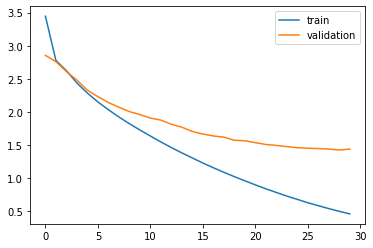

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

<h1> Prediction on unseen data</h1>

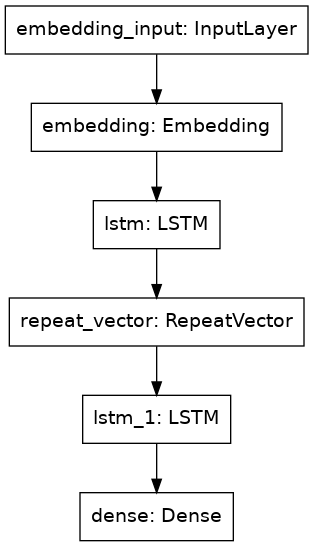

In [20]:
tf.keras.utils.plot_model(model)

In [21]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [22]:
import numpy as np
preds1 = np.argmax(model.predict(testX.reshape((testX.shape[0],testX.shape[1]))),axis = 1)

In [23]:
preds1

array([[7, 0, 4, ..., 1, 4, 1],
       [7, 0, 1, ..., 1, 1, 1],
       [7, 0, 0, ..., 1, 1, 1],
       ...,
       [6, 2, 0, ..., 0, 0, 0],
       [7, 0, 2, ..., 1, 3, 1],
       [7, 2, 1, ..., 2, 2, 2]])

In [24]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [25]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [26]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [27]:
# print 15 rows randomly
pred_df.head(15)

,actual,predicted
0,im glad to hear it,im glad to hear it
1,its dead,its dead
2,keep climbing,keep climbing
3,i respect you,i find you
4,what did you do then,what did you do
5,ill give you a hint,ill give you a favor
6,have they arrived yet,are they born ready
7,she knows everything,she knows everything
8,i hope its true,i think this true
9,they robbed me blind,they robbed me blind
